In [18]:
# conda install -c anaconda mysql-connector-python
import mysql.connector
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy import stats
from functools import reduce

#bokeh
#Flask Web Development

In [35]:
db=pd.read_csv('../Data/Mint/DB.csv')

cnx = mysql.connector.connect(
  host=db['host'][0],
  user=db['user'][0],
  password=db['password'][0],
  database= db['database'][0]
)

MthOrder = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


## Fixed Budgets

In [36]:
#Get all transactions 
#Resample and get statisitics
# where transdate >= '2018-01-01'
Transactions_F = pd.read_sql("Select * from budget_Fixed ", con=cnx,parse_dates=['transdate'],index_col='transdate')
Monthly_F = pd.DataFrame( Transactions_F.resample('M')['amount'].sum())


Mu = Monthly_F.amount.mean()
Sigma = np.std(Monthly_F['amount'])

# how many standard Deviations away is each value
# (x-Mean)/Standard Deviation
# Monthly['Z_ScoreTest']=((Monthly['amount']-Mu)/Sigma)

Monthly_F['Z_Score']= stats.zscore(Monthly_F['amount'])
Monthly_F['Target'] = Monthly_F['Z_Score'] <0




print('Fixed Monthly Total Mean: {}\nFixed Monthly Total StandardDev:{}'.format(Mu,Sigma))
print(Monthly_F['Target'].value_counts())

Fixed Monthly Total Mean: 1784.9869444444444
Fixed Monthly Total StandardDev:648.7273674614331
True     61
False    47
Name: Target, dtype: int64


''

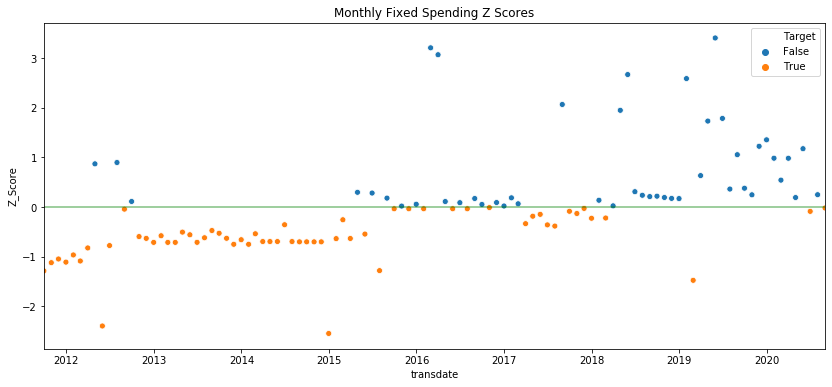

In [37]:
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize = [14,6])

sns.scatterplot(x=Monthly_F.index,y='Z_Score',data=Monthly_F,ax=ax1,hue='Target')
sns.lineplot(x=Monthly_F.index,y=0,data=Monthly_F,ax=ax1,alpha=.5,color='Green')

ax1.set_xlim(Monthly_F.index.min(), Monthly_F.index.max())
ax1.set_title('Monthly Fixed Spending Z Scores')
plt.savefig('./Images/Monthly_Fixed_Z.png', dpi=300)
;



In [38]:
# Pare down transactions to next month - 1 year
d = datetime.today() + pd.offsets.MonthBegin(1)
d = d - relativedelta(years=1)
Fixed = Transactions_F.loc[Transactions_F.index >= d]
new_datetime_range = pd.date_range(start=Fixed.index.min(), end=datetime.today(), freq="D")



Fixed_Matrix = Fixed.resample('D').sum().reindex(new_datetime_range,fill_value=0)
Fixed_Matrix = pd.pivot_table(Fixed_Matrix
                              ,index = Fixed_Matrix.index.day
                              ,columns = Fixed_Matrix.index.strftime('%b')
                              ,values= "amount"
                             )

Fixed_Matrix = Fixed_Matrix.cumsum()
Fixed_Matrix.sort_index(level=0,ascending=False,inplace=True)
Fixed_Matrix=Fixed_Matrix.reindex(columns=MthOrder)

# Fixed_Matrix.head(31)



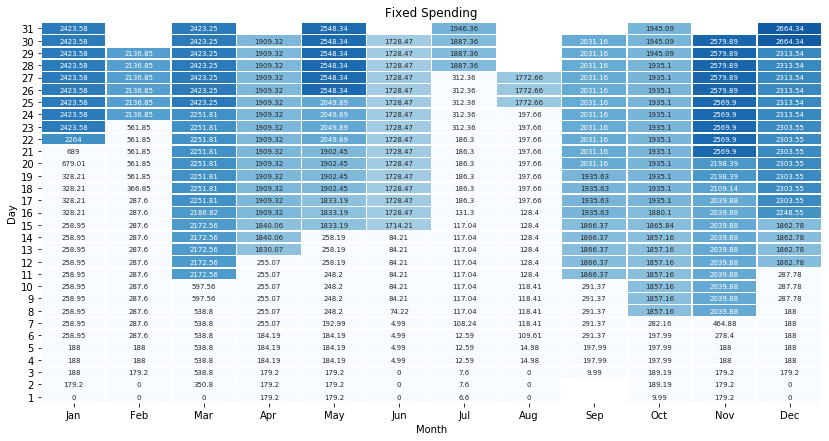

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[14, 7])
sns.heatmap(Fixed_Matrix,
            annot=True,
            annot_kws={"size": 7},
            vmin=1000,
            vmax=3000,
            fmt="g",
            linewidths=.5,
            cbar=False,
            cmap="Blues",
            ax=ax)
plt.title('Fixed Spending')
ax.set_xlabel('Month')
ax.set_ylabel('Day')

plt.savefig('./Images/Daily_Fixed_Heat.png', dpi=300)

''

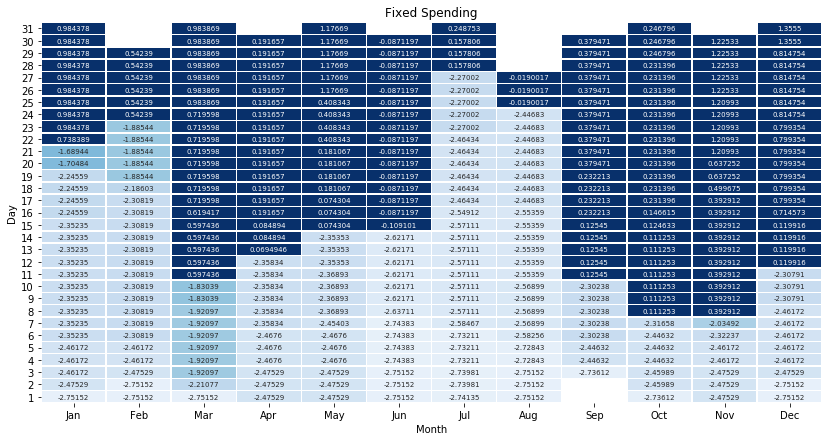

In [24]:
Fixed_Matrix_z = Fixed_Matrix.apply(lambda x : (x-Mu)/Sigma)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[14, 7])
sns.heatmap(Fixed_Matrix_z,
            annot=True,
            annot_kws={"size": 7},
            vmin=-3,
            vmax=-.1,
            fmt="g",
            linewidths=.5,
            cbar=False,
            cmap="Blues",
            ax=ax)
plt.title('Fixed Spending')
ax.set_xlabel('Month')
ax.set_ylabel('Day')
plt.savefig('./Images/Daily_Fixed_Heat_Z.png', dpi=300)
;


In [25]:
Fixed_Budget = Transactions_F.groupby(by='category').agg(Mean = ('amount','mean')
                                        ,Total = ('amount','sum')
                                        ,Count = ('id','count')
                                        ).sort_values (by='Count', ascending=False)

end_date = Transactions_F.index.max()
start_date = Transactions_F.index.min()
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

Fixed_Budget['Per_Month']=Fixed_Budget.Total.apply(lambda x : x / num_months)
# Fixed_Budget.sort_values(by='Per_Month',ascending=False)



Fixed_Budget_Month=Fixed.groupby(by=[Fixed.index.month,'category']).agg(Mean = ('amount','mean')
                                        ,Total = ('amount','sum')
                                        ,Count = ('id','count')
                                        )

In [26]:
Mth = 8
Fixed_Budget_Month[['Total']].loc[Mth].merge(Fixed_Budget['Per_Month'],on='category',how='outer').sort_values(by='Total',ascending=False)



#ThisMonth = Fixed_Budget_Month[['Total']].loc[Mth]
#PriorMonth = Fixed_Budget_Month[['Total']].loc[Mth-1]

#dfs = [ThisMonth,PriorMonth,Fixed_Budget['Per_Month']]
#df_final = reduce(lambda left,right: pd.merge(left,right,on='category'), dfs)

#df_final.head(20)


,Total,Per_Month
category,,
Mortgage & Rent,1575.00,1349.220093
Mobile Phone,94.63,57.281308
Internet,55.00,46.399813
Subscription_Service,48.03,11.151215
Auto Insurance,NaN,128.895981
Home Insurance,NaN,7.269813
Utilities,NaN,48.140093
Auto Payment,NaN,94.672897
Education,NaN,37.083925


## Discretionary Budgets

In [27]:
#Get all transactions 
#Resample and get statisitics
Transactions_D = pd.read_sql('Select * from budget_Discretionary', con=cnx,parse_dates=['transdate'],index_col='transdate')
Monthly = pd.DataFrame( Transactions_D.resample('M')['amount'].sum())


Mu = Monthly.amount.mean()
Sigma = np.std(Monthly['amount'])

# how many standard Deviations away is each value
# (x-Mean)/Standard Deviation
# Monthly['Z_ScoreTest']=((Monthly['amount']-Mu)/Sigma)

Monthly['Z_Score']= stats.zscore(Monthly['amount'])
Monthly['Target'] = Monthly['Z_Score'] <0

print('Discretionary Monthly Total Mean: {}\nDiscretionary Monthly Total StandardDev:{}'.format(Mu,Sigma))
print(Monthly['Target'].value_counts())

Discretionary Monthly Total Mean: 2241.1175925925936
Discretionary Monthly Total StandardDev:661.5526454315922
True     58
False    50
Name: Target, dtype: int64


''

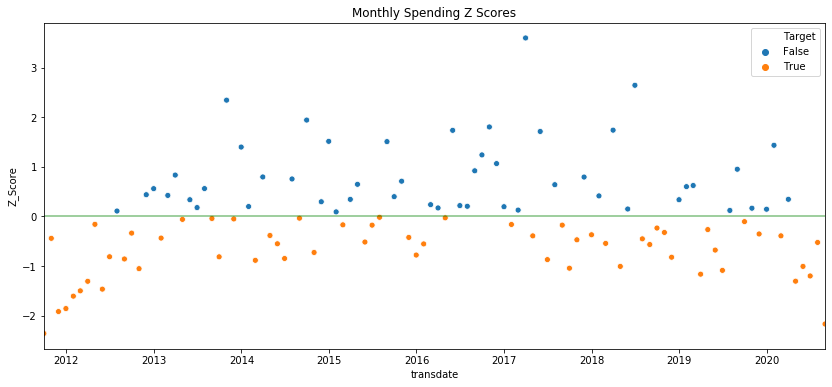

In [28]:
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize = [14,6])

sns.scatterplot(x=Monthly.index,y='Z_Score',data=Monthly,ax=ax1,hue='Target')
sns.lineplot(x=Monthly.index,y=0,data=Monthly,ax=ax1,alpha=.5,color='Green')

ax1.set_xlim(Monthly.index.min(), Monthly.index.max())
ax1.set_title('Monthly Spending Z Scores')
plt.savefig('./Images/Monthly_Discretionary_Z.png', dpi=300)
;

In [29]:
# Pare down transactions to next month - 1 year

d = datetime.today() + pd.offsets.MonthBegin(1)
d = d - relativedelta(years=1)

Discretionary = Transactions_D.loc[Transactions_D.index >= d]


new_datetime_range = pd.date_range(start=Discretionary.index.min(), end=datetime.today(), freq="D")




Discretionary_Matrix = Discretionary.resample('D').sum().reindex(new_datetime_range,fill_value=0)
Discretionary_Matrix = pd.pivot_table(Discretionary_Matrix
                              ,index = Discretionary_Matrix.index.day
                              ,columns = Discretionary_Matrix.index.strftime('%b')
                              ,values= "amount"
                             )

Discretionary_Matrix = Discretionary_Matrix.cumsum()
Discretionary_Matrix.sort_index(level=0,ascending=False,inplace=True)
Discretionary_Matrix=Discretionary_Matrix.reindex(columns=MthOrder)


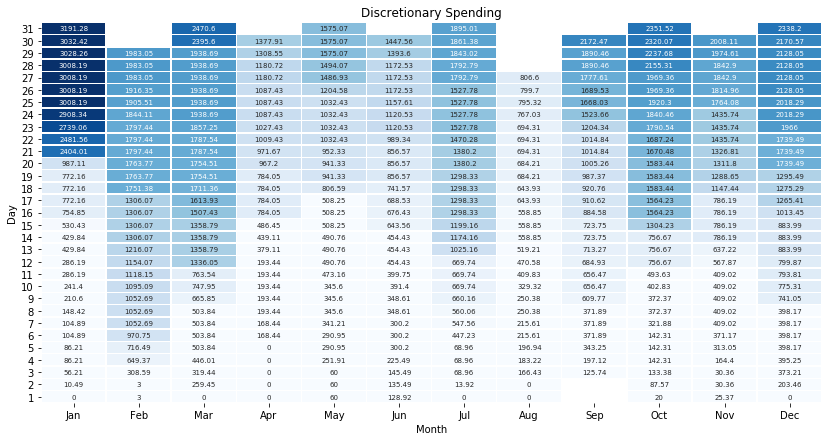

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[14, 7])
sns.heatmap(Discretionary_Matrix,
            annot=True,
            annot_kws={"size": 7},
            vmin=500,
            vmax=3000,
            fmt="g",
            linewidths=.5,
            cbar=False,
            cmap="Blues",
            ax=ax)
plt.title('Discretionary Spending')
ax.set_xlabel('Month')
ax.set_ylabel('Day')
plt.savefig('./Images/Daily_Discretionary_Heat.png', dpi=300)

''

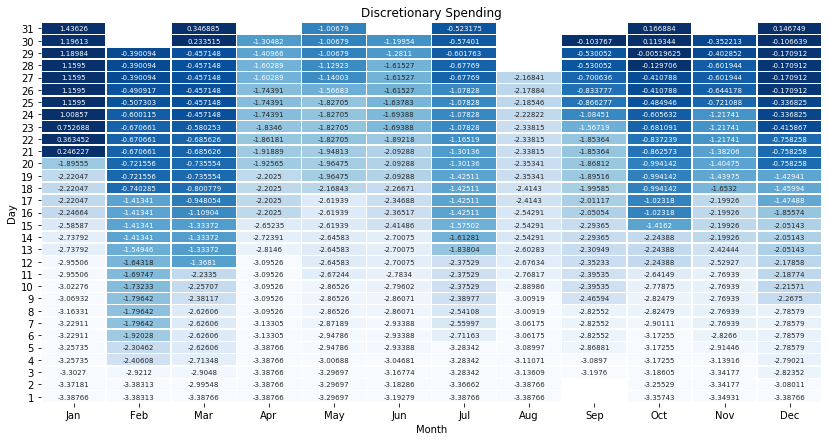

In [31]:
Discretionary_Matrix_z = Discretionary_Matrix.apply(lambda x : (x-Mu)/Sigma)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[14, 7])
sns.heatmap(Discretionary_Matrix_z,
            annot=True,
            annot_kws={"size": 7},
            vmin=-3,
            vmax=-.1,
            fmt="g",
            linewidths=.5,
            cbar=False,
            cmap="Blues",
            ax=ax)
plt.title('Discretionary Spending')
ax.set_xlabel('Month')
ax.set_ylabel('Day')
plt.savefig('./Images/Daily_Discretionary_Heat_Z.png', dpi=300)
;

In [32]:
#Transactions_D is the entire dataset. This making averages back to ~2011
Discretionary_Budget = Transactions_D.groupby(by='category').agg(Mean = ('amount','mean')
                                        ,Total = ('amount','sum')
                                        ,Count = ('id','count')
                                        ).sort_values (by='Count', ascending=False)

end_date = Transactions_D.index.max()
start_date = Transactions_D.index.min()
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

Discretionary_Budget['Per_Month']=Discretionary_Budget.Total.apply(lambda x : x / num_months)
# Discretionary_Budget.sort_values(by='Per_Month',ascending=False)



#Grouping by month with the data used for the Heat Map (Discretionary)
Discretionary_Budget_Month=Discretionary.groupby(by=[Discretionary.index.month,'category']).agg(Mean = ('amount','mean')
                                        ,Total = ('amount','sum')
                                        ,Count = ('id','count')
                                        )

In [33]:
Mth = 8
Discretionary_Budget_Month[['Total']].loc[Mth].merge(Discretionary_Budget['Per_Month'],on='category',how='left').sort_values(by='Per_Month',ascending=False).head(50)


#Total is wahat you spent on that category in Mth, Per_Month is the average over the last 12 months

                                                


,Total,Per_Month
category,,
Shopping,35.98,290.720935
Groceries,312.80,258.129626
Alcohol & Bars,222.32,236.952991
Entertainment,60.00,177.078972
Restaurants,34.77,157.740093
Gas & Fuel,63.77,96.094953
Coffee Shops,36.96,35.634953
Rental Car & Taxi,15.00,15.640000
Bank Fee,25.00,2.208037


In [34]:
Discretionary_Budget_Month[['Total']].loc[Mth].merge(Discretionary_Budget_Month[['Total']].loc[Mth-2],on='category',how='outer')


,Total_x,Total_y
category,,
Alcohol & Bars,222.32,183.06
Bank Fee,25.00,25.00
Coffee Shops,36.96,97.89
Entertainment,60.00,147.31
Gas & Fuel,63.77,100.03
Groceries,312.80,488.00
Rental Car & Taxi,15.00,NaN
Restaurants,34.77,16.21
Shopping,35.98,226.47
